# Lets just do supervised learning

Since we are looking at pairs with random permuations (from dropout), we can't use CCS. This is because our probabilities do not add to one.

People question if unsupervised learning bings anything to the table anyway, so lets start with supervised...


This one is `dual` in that itpasses both parts of the pair into the model at once.

```
x = torch.concat([x0, x1], 1)
y_pred =model(x)
loss(y_pred, y)
```
as opposed to
```
logit0 = model(x0)
logit1 = model(x1)
y_pred = torch.concat([logit0, logit1])
loss(y_pred, y)
```

TODO:
- [ ] fix training curves?
- [ ] fix acc metrics, maybe look at nicks custom metrics


links:
- [loading](https://github.com/deep-diver/LLM-As-Chatbot/blob/main/models/alpaca.py)
- [dict](https://github.com/deep-diver/LLM-As-Chatbot/blob/c79e855a492a968b54bac223e66dc9db448d6eba/model_cards.json#L143)
- [prompt_format](https://github.com/deep-diver/PingPong/blob/main/src/pingpong/alpaca.py)

In [1]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from typing import Optional, List, Dict, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path

import transformers


import lightning.pytorch as pl
# from dataclasses import dataclass

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import RobustScaler

from tqdm.auto import tqdm
import os

from loguru import logger
logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")

transformers.__version__

'4.30.1'

In [2]:
from datasets import load_from_disk, concatenate_datasets
fs = [
    # "./.ds/HuggingFaceH4starchat_beta-None-N_4000-ns_3-mc_0.2-8bf3e5",
    # './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e',
    # './.ds/HuggingFaceH4starchat_beta-None-N_600-ns_3-mc_0.2-f0d838',
    
    # './.ds/HuggingFaceH4starchat_beta-None-N_4000-ns_3-mc_0.2-0392de',
    './.ds/HuggingFaceH4starchat_beta-None-N_6000-ns_3-mc_True-dc99f8',
    './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_True-a50b5f'
]

# './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e'
ds = concatenate_datasets([load_from_disk(f) for f in fs])
ds

Dataset({
    features: ['hs1', 'ans1', 'hs2', 'ans2', 'true', 'index', 'version', 'info', 'input_truncated', 'prob_y', 'prob_n', 'text_ans', 'input_text'],
    num_rows: 28000
})

In [3]:
# fs

In [4]:
# from datasets import load_from_disk, Dataset, load_dataset, load_dataset_builder
# f="./.ds/HuggingFaceH4starchat_beta-None-N_4000-ns_3-mc_0.2-8bf3e5_builder/"
# # ds = Dataset.from_file(f)
# fs=[str(s) for s in Path(f).glob('*.arrow')]
# ds = load_dataset(f, data_files=fs, split="train")
# # load_dataset_builder(f)

## Lightning DataModule

What are we detecting?

We have a pair of inputs, for differen't dropouts. During training we know that one is in the direciton of truth/deception/error

During inferance we also have a pair but don't know which is slower to what we want.

In [5]:
def ds_info2df(ds):
    d = pd.DataFrame(list(ds['info']))
    return d

def ds2df(ds):
    df = ds_info2df(ds)
    df_ans = ds.select_columns(['ans1', 'ans2', 'true']).with_format("numpy").to_pandas()
    df = pd.concat([df, df_ans], axis=1)
    
    # derived
    df['dir_true'] = df['ans2'] - df['ans1']
    df['conf'] = (df['ans1']-df['ans2']).abs()  
    df['llm_prob'] = (df['ans1']+df['ans2'])/2
    df['llm_ans'] = df['llm_prob']>0.5
    return df

class imdbHSDataModule(pl.LightningDataModule):

    def __init__(self,
                 ds,
                 batch_size=32,
                ):
        super().__init__()
        self.save_hyperparameters(ignore=["ds"])
        self.ds = ds

    def setup(self, stage: str):
        h = self.hparams
        
        # extract data set into N-Dim tensors and 1-d dataframe
        self.ds_hs = (
            self.ds.select_columns(['hs1', 'hs2'])
            .with_format("numpy")
        )
        self.df = ds2df(ds)
        
        self.y = self.df['true_answer'].astype(np.float32).values # detection of true answer
        self.y = (self.df['true_answer'] == (self.df['dir_true']>0)).values # is the direction in the dir of truth
        self.y = (self.df['lie'] * ((self.df['llm_ans']>0.5)==self.df['desired_answer']) *  (self.df['dir_true']>0)).values.astype(float) # deception
        self.df['y'] = self.y
        
        b = len(self.ds_hs)
        self.hs1 = self.ds_hs['hs1'].reshape((b, -1))#.numpy()
        self.hs2 = self.ds_hs['hs2'].reshape((b, -1))#.numpy()        
        self.ans1 = self.df['ans1'].values
        self.ans2 = self.df['ans2'].values

        # let's create a simple 50/50 train split (the data is already randomized)
        n = len(self.y)
        self.val_split = vs = int(n * 0.5)
        self.test_split = ts = int(n * 0.75)
        hs1_train, hs2_train, y_train = self.hs1[:vs], self.hs2[:vs], self.y[:vs]
        hs1_val, hs2_val, y_val = self.hs1[vs:ts], self.hs2[vs:ts], self.y[vs:ts]
        hs1_test, hs2_test, y_test = self.hs1[ts:],self. hs2[ts:], self.y[ts:]

        self.ds_train = TensorDataset(torch.from_numpy(hs1_train).float(),
                                      torch.from_numpy(hs2_train).float(),
                                      torch.from_numpy(y_train).float())

        self.ds_val = TensorDataset(torch.from_numpy(hs1_val).float(),
                                    torch.from_numpy(hs2_val).float(),
                                    torch.from_numpy(y_val).float())

        self.ds_test = TensorDataset(torch.from_numpy(hs1_test).float(),
                                     torch.from_numpy(hs2_test).float(),
                                     torch.from_numpy(y_test).float())

    def train_dataloader(self):
        return DataLoader(self.ds_train,
                          batch_size=self.hparams.batch_size,
                          shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.hparams.batch_size)

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.hparams.batch_size)


In [6]:
batch_size = 128
# test and cache
dm = imdbHSDataModule(ds, batch_size=batch_size)
dm.setup('train')

dl_val = dm.val_dataloader()
dl_train = dm.train_dataloader()
b = next(iter(dl_train))
b

[tensor([[-0.0663,  0.0422, -0.0305,  ..., -2.2988,  4.8789,  4.8203],
         [ 0.0133,  0.0310, -0.0402,  ..., -0.8950,  1.4668,  5.5664],
         [-0.1559, -0.0199, -0.0368,  ..., -3.2812, -0.3250,  6.6172],
         ...,
         [-0.1753,  0.0316, -0.0417,  ..., -2.6172, -3.3281,  3.5938],
         [-0.1921,  0.0181, -0.0429,  ..., -7.0430, -0.5029,  3.0645],
         [-0.0497,  0.0388, -0.0245,  ..., -3.4453, -2.3965,  4.2969]]),
 tensor([[-9.3384e-02,  5.2734e-02, -5.0476e-02,  ..., -4.0117e+00,
          -1.2256e-01,  2.2637e+00],
         [-1.2939e-01, -4.9591e-03, -3.9368e-03,  ...,  1.0693e-01,
           1.8027e+00,  3.4531e+00],
         [-1.5222e-01, -2.2903e-02, -3.5858e-02,  ..., -3.5547e+00,
           2.5703e+00,  6.9609e+00],
         ...,
         [-1.4502e-01, -3.5477e-03, -3.2196e-02,  ..., -4.6641e+00,
           9.8096e-01,  1.4951e+00],
         [-1.9177e-01, -1.0742e-02, -6.2927e-02,  ..., -5.2344e+00,
          -7.5391e-01,  4.7695e+00],
         [-5.3650e-

In [7]:
# %debug

In [8]:

hss1 = dm.hs1
hss2 = dm.hs2
ans_1 = dm.ans1
ans_2 = dm.ans2
y = dm.y
print('y_balance', y.mean())
df = dm.df
df

y_balance 0.03339285714285714


,desired_answer,input,lie,true_answer,version,ans1,ans2,true,dir_true,conf,llm_prob,llm_ans,y
0,True,Title: Horrible and dangerous for kids!\n\nCon...,True,0,lie,0.074707,0.095276,0,0.020569,0.020569,0.084991,False,0.0
1,False,Title: Great television.\n\nContent: I found m...,True,1,lie,0.489990,0.544434,1,0.054443,0.054443,0.517212,True,0.0
2,True,Title: Not good\n\nContent: I luv Johanna Lind...,True,0,lie,0.018829,0.028839,0,0.010010,0.010010,0.023834,False,0.0
3,False,Title: unfinished business\n\nContent: Once ag...,True,1,lie,0.594238,0.571289,1,-0.022949,0.022949,0.582764,True,0.0
4,True,Title: The box listing does not match what's o...,True,0,lie,0.003170,0.013206,0,0.010036,0.010036,0.008188,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,True,Review Title: Great for burning CDS\n\nReview ...,False,1,truth,0.522949,0.745117,1,0.222168,0.222168,0.634033,True,0.0
27996,False,Review Title: Horrible...\n\nReview Content: I...,False,0,truth,0.001739,0.001056,0,-0.000683,0.000683,0.001397,False,0.0
27997,False,Review Title: one of the worst books to use fo...,False,0,truth,0.016632,0.000480,0,-0.016152,0.016152,0.008556,False,0.0
27998,False,"Review Title: Not for C, C++ programmers\n\nRe...",False,0,truth,0.005379,0.008308,0,0.002930,0.002930,0.006844,False,0.0


# Data prep

We do two inferences on the same inputs. Since we have dropout enabled, even during inference, we get two slightly different hidden states `hs1` and `hs2`, and two slightly different probabilities for our yes and no output tokens `p1` `p2`. We also have the true answer `t`

So there are a few ways we can set up the problem. 

We can vary x:
- `model(hs1)-model(hs2)=y`
- `model(hs1-hs2)==y`

And we can try differen't y's:
- direction with a ranked loss. This could be unsupervised.
- magnitude with a regression loss
- vector (direction and magnitude) with a regression loss

# QC: Linear supervised probes


Let's verify that the model's representations are good

Before trying CCS, let's make sure there exists a direction that classifies examples as true vs false with high accuracy; if supervised logistic regression accuracy is bad, there's no hope of unsupervised CCS doing well.

Note that because logistic regression is supervised we expect it to do better but to have worse generalisation that equivilent unsupervised methods. However in this case CSS is using a deeper model so it is more complicated.


## Try a classification of direction to truth

In [10]:
n = len(df)

# Define X and y
X = hss1-hss2

# split
n = len(y)
print('split size', n//2)
X_train, X_test = X[:n//2], X[n//2:]
y_train, y_test = y[:n//2], y[n//2:]
X_train = X_train[:4000]
y_train = y_train[:4000]
# scale
scaler = RobustScaler()
scaler.fit(X_train[:1000])
X_train2 = scaler.transform(X_train)
X_test2 = scaler.transform(X_test)
print('lr')

lr = LogisticRegression(class_weight="balanced", penalty="l2", max_iter=380)
lr.fit(X_train2, y_train>0)

split size 14000
lr


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:20                                                                                   │
│                                                                                                  │
│   17 print('lr')                                                                                 │
│   18                                                                                             │
│   19 lr = LogisticRegression(class_weight="balanced", penalty="l2", max_iter=380)                │
│ ❱ 20 lr.fit(X_train2, y_train>0)                                                                 │
│   21                                                                                             │
│                                                                                                  │
│ /home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py: │
│ 1196 in fit                                                                                      │
│                                                                                                  │
│   1193 │   │   else:                                                                             │
│   1194 │   │   │   _dtype = [np.float64, np.float32]                                             │
│   1195 │   │                                                                                     │
│ ❱ 1196 │   │   X, y = self._validate_data(                                                       │
│   1197 │   │   │   X,                                                                            │
│   1198 │   │   │   y,                                                                            │
│   1199 │   │   │   accept_sparse="csr",                                                          │
│                                                                                                  │
│ /home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/sklearn/base.py:584 in             │
│ _validate_data                                                                                   │
│                                                                                                  │
│    581 │   │   │   │   │   check_y_params = {**default_check_params, **check_y_params}           │
│    582 │   │   │   │   y = check_array(y, input_name="y", **check_y_params)                      │
│    583 │   │   │   else:                                                                         │
│ ❱  584 │   │   │   │   X, y = check_X_y(X, y, **check_params)                                    │
│    585 │   │   │   out = X, y                                                                    │
│    586 │   │                                                                                     │
│    587 │   │   if not no_val_X and check_params.get("ensure_2d", True):                          │
│                                                                                                  │
│ /home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/sklearn/utils/validation.py:1124   │
│ in check_X_y                                                                                     │
│                                                                                                  │
│   1121 │                                                                                         │
│   1122 │   y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)  │
│   1123 │                                                                                         │
│ ❱ 1124 │   check_consistent_length(X, y)                                                         │
│   1125 │                                                                                         │
│   1126 │   return X, y                                     

In [11]:
print("Logistic cls acc: {:2.2%} [TRAIN]".format(lr.score(X_train2, y_train>0)))
print("Logistic cls acc: {:2.2%} [TEST]".format(lr.score(X_test2, y_test>0)))

m = df['lie'][n//2:]
y_test_pred = lr.predict(X_test2)
acc_w_lie = ((y_test_pred[m]>0)==(y_test[m]>0)).mean()
acc_wo_lie = ((y_test_pred[~m]>0)==(y_test[~m]>0)).mean()
print(f'test acc w lie {acc_w_lie:2.2%}')
print(f'test acc wo lie {acc_wo_lie:2.2%}')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱  1 print("Logistic cls acc: {:2.2%} [TRAIN]".format(lr.score(X_train2, y_train>0)))            │
│    2 print("Logistic cls acc: {:2.2%} [TEST]".format(lr.score(X_test2, y_test>0)))               │
│    3                                                                                             │
│    4 m = df['lie'][n//2:]                                                                        │
│                                                                                                  │
│ /home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/sklearn/base.py:668 in score       │
│                                                                                                  │
│    665 │   │   """                                                                               │
│    666 │   │   from .metrics import accuracy_score                                               │
│    667 │   │                                                                                     │
│ ❱  668 │   │   return accuracy_score(y, self.predict(X), sample_weight=sample_weight)            │
│    669 │                                                                                         │
│    670 │   def _more_tags(self):                                                                 │
│    671 │   │   return {"requires_y": True}                                                       │
│                                                                                                  │
│ /home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/sklearn/linear_model/_base.py:419  │
│ in predict                                                                                       │
│                                                                                                  │
│   416 │   │   │   Vector containing the class labels for each sample.                            │
│   417 │   │   """                                                                                │
│   418 │   │   xp, _ = get_namespace(X)                                                           │
│ ❱ 419 │   │   scores = self.decision_function(X)                                                 │
│   420 │   │   if len(scores.shape) == 1:                                                         │
│   421 │   │   │   indices = xp.astype(scores > 0, int)                                           │
│   422 │   │   else:                                                                              │
│                                                                                                  │
│ /home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/sklearn/linear_model/_base.py:397  │
│ in decision_function                                                                             │
│                                                                                                  │
│   394 │   │   │   binary case, confidence score for `self.classes_[1]` where >0 means            │
│   395 │   │   │   this class would be predicted.                                                 │
│   396 │   │   """                                                                                │
│ ❱ 397 │   │   check_is_fitted(self)                                                              │
│   398 │   │   xp, _ = get_namespace(X)                                                           │
│   399 │   │                                                                                      │
│   400 │   │   X = self._validate_data(X, accept_sparse="csr", reset=False)                       │
│                                                            

In [12]:
df_info_test = df.iloc[n//2:].copy()
y_pred = lr.predict(X_test2)
df_info_test['inner_truth'] = y_pred
df_info_test

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 df_info_test = df.iloc[n//2:].copy()                                                         │
│ ❱ 2 y_pred = lr.predict(X_test2)                                                                 │
│   3 df_info_test['inner_truth'] = y_pred                                                         │
│   4 df_info_test                                                                                 │
│   5                                                                                              │
│                                                                                                  │
│ /home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/sklearn/linear_model/_base.py:419  │
│ in predict                                                                                       │
│                                                                                                  │
│   416 │   │   │   Vector containing the class labels for each sample.                            │
│   417 │   │   """                                                                                │
│   418 │   │   xp, _ = get_namespace(X)                                                           │
│ ❱ 419 │   │   scores = self.decision_function(X)                                                 │
│   420 │   │   if len(scores.shape) == 1:                                                         │
│   421 │   │   │   indices = xp.astype(scores > 0, int)                                           │
│   422 │   │   else:                                                                              │
│                                                                                                  │
│ /home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/sklearn/linear_model/_base.py:397  │
│ in decision_function                                                                             │
│                                                                                                  │
│   394 │   │   │   binary case, confidence score for `self.classes_[1]` where >0 means            │
│   395 │   │   │   this class would be predicted.                                                 │
│   396 │   │   """                                                                                │
│ ❱ 397 │   │   check_is_fitted(self)                                                              │
│   398 │   │   xp, _ = get_namespace(X)                                                           │
│   399 │   │                                                                                      │
│   400 │   │   X = self._validate_data(X, accept_sparse="csr", reset=False)                       │
│                                                                                                  │
│ /home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/sklearn/utils/validation.py:1390   │
│ in check_is_fitted                                                                               │
│                                                                                                  │
│   1387 │   │   ]                                                                                 │
│   1388 │                                                                                         │
│   1389 │   if not fitted:                                                                        │
│ ❱ 1390 │   │   raise NotFittedError(msg % {"name": type(estimator).__name__})                    │
│   1391                                                                                           │
│   1392                                                     

### Result, detecting deception?

In [13]:
lie_pred = df_info_test['inner_truth']==df_info_test['true_answer']
lie_true = df_info_test['lie']
acc_lie = accuracy_score(lie_pred, lie_true)
print(f"model can detect lies with acc {acc_lie:2.2%}")
print(f"w lies {sum(lie_true)}/{len(lie_true)} test rows")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/pandas/core/indexes/base.py:3652   │
│ in get_loc                                                                                       │
│                                                                                                  │
│   3649 │   │   """                                                                               │
│   3650 │   │   casted_key = self._maybe_cast_indexer(key)                                        │
│   3651 │   │   try:                                                                              │
│ ❱ 3652 │   │   │   return self._engine.get_loc(casted_key)                                       │
│   3653 │   │   except KeyError as err:                                                           │
│   3654 │   │   │   raise KeyError(key) from err                                                  │
│   3655 │   │   except TypeError:                                                                 │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:147                                                    │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:176                                                    │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:7080                                        │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:7088                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'inner_truth'

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 lie_pred = df_info_test['inner_truth']==df_info_test['true_answer']                          │
│   2 lie_true = df_info_test['lie']                                                               │
│   3 acc_lie = accuracy_score(lie_pred, lie_true)                                                 │
│   4 print(f"model can detect lies with acc {acc_lie:2.2%}")                                      │
│                                                                                                  │
│ /home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/pandas/core/frame.py:3761 in       │
│ __getitem__                                                                                      │
│                                                                                                  │
│    3758 │   │   if is_single_key:                                                                │
│    3759 │   │   │   if self.columns.nlevels > 1:                                                 │
│    3760 │   │   │   │   return self._getitem_multilevel(key)                                     │
│ ❱  3761 │   │   │   indexer = self.columns.get_loc(key)                                          │
│    3762 │   │   │   if is_integer(indexer):                                                      │
│    3763 │   │   │   │   indexer = [indexer]                                                      │
│    3764 │   │   else:                                                                            │
│                                                                  

# LightningModel

In [14]:
class MLPProbe(nn.Module):
    def __init__(self, c_in, depth=0, hs=16, dropout=0):
        super().__init__()

        layers = [
            nn.Dropout1d(dropout),
            nn.BatchNorm1d(c_in),  # this will normalise the inputs
            nn.Linear(c_in, hs),
            nn.Dropout1d(dropout),
        ]
        for _ in range(depth):
            layers += [
                nn.Linear(hs, hs),
                nn.ReLU(),
                nn.Dropout1d(dropout),
            ]
        layers += [nn.Linear(hs, 2)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [15]:
class_weights = 1/torch.Tensor(pd.Series(y).value_counts(True).values)
class_weights /= class_weights.sum()
class_weights

tensor([0.0334, 0.9666])

In [16]:
from pytorch_optimizer import Ranger21
import torchmetrics
# from focal_loss.focal_loss import FocalLoss

from torchmetrics import Metric, MetricCollection, Accuracy, AUROC
    
class CSS(pl.LightningModule):
    def __init__(self, c_in, total_steps, depth=1, hs=16, lr=4e-3, weight_decay=1e-9, dropout=0):
        super().__init__()
        self.probe = MLPProbe(c_in*2, depth=depth, dropout=dropout, hs=hs)
        self.save_hyperparameters()
        
        # self.loss_fn = FocalLoss(0.7)
        self.loss_fn = nn.CrossEntropyLoss(class_weights)
        
        # metrics for each stage
        metrics_template = MetricCollection({
            'acc': Accuracy(task="multiclass", num_classes=2), 
            'auroc': AUROC(task="multiclass", num_classes=2)
        })
        self.metrics = torch.nn.ModuleDict({
            f'metrics_{stage}': metrics_template.clone(prefix=stage+'/') for stage in ['train', 'val', 'test']
        })
        
    def forward(self, x):
        return self.probe(x)
        
    def _step(self, batch, batch_idx, stage='train'):
        x0, x1, y = batch
        x = torch.concatenate([x0, x1], 1)
        logits = self(x)
        y_pred = F.softmax(logits, -1)
        if stage=='pred':
            return y_pred
        
        loss = self.loss_fn(y_pred, y.long())
        self.log(f"{stage}/loss", loss)
        
        m = self.metrics[f'metrics_{stage}']
        m(y_pred, y.long())
        self.log_dict(m, on_epoch=True, on_step=False)
        return loss
    
    def training_step(self, batch, batch_idx=0, dataloader_idx=0):
        return self._step(batch, batch_idx)
    
    def validation_step(self, batch, batch_idx=0):
        return self._step(batch, batch_idx, stage='val')
    
    def predict_step(self, batch, batch_idx=0, dataloader_idx=0):
        return self._step(batch, batch_idx, stage='pred').cpu().detach()
    
    def test_step(self, batch, batch_idx=0, dataloader_idx=0):
        return self._step(batch, batch_idx, stage='test')
    
    def configure_optimizers(self):
        """use ranger21 from  https://github.com/kozistr/pytorch_optimizer"""
        optimizer = Ranger21(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,       
            num_iterations=self.hparams.total_steps,
        )
        return optimizer
    
    

# Run

In [17]:
# quiet please
torch.set_float32_matmul_precision('medium')

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*F-score.*")

## Prep dataloader/set

In [18]:
# # split
# X = hss1-hss2
# y = (df['true_answer'] == (df['dir_true']>0)).values # does this dropout take it in the direction of truth
# y = df['lie'] * ((df['llm_ans']>0.5)==df['desired_answer']) # deception
# n = len(y)
# print('split size', n//2)

# neg_hs_train = hss1[:n//2]
# pos_hs_train = hss2[:n//2]

# neg_hs_val = hss1[n//2:]
# pos_hs_val = hss2[n//2:]

# y_train, y_val = y[:n//2], y[n//2:]

In [19]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
b = next(iter(dl_train))
# b

In [20]:
# init the model
max_epochs = 16
c_in = b[0].shape[-1]
print(b[0].shape)
net = CSS(c_in=c_in, total_steps=max_epochs*len(dl_train), depth=1, hs=8, lr=1e-3, weight_decay=1e-4, dropout=0.1)
net

torch.Size([128, 116736])


CSS(
  (probe): MLPProbe(
    (net): Sequential(
      (0): Dropout1d(p=0.1, inplace=False)
      (1): BatchNorm1d(233472, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Linear(in_features=233472, out_features=8, bias=True)
      (3): Dropout1d(p=0.1, inplace=False)
      (4): Linear(in_features=8, out_features=8, bias=True)
      (5): ReLU()
      (6): Dropout1d(p=0.1, inplace=False)
      (7): Linear(in_features=8, out_features=2, bias=True)
    )
  )
  (loss_fn): CrossEntropyLoss()
  (metrics): ModuleDict(
    (metrics_train): MetricCollection(
      (acc): MulticlassAccuracy()
      (auroc): MulticlassAUROC(),
      prefix=train/
    )
    (metrics_val): MetricCollection(
      (acc): MulticlassAccuracy()
      (auroc): MulticlassAUROC(),
      prefix=val/
    )
    (metrics_test): MetricCollection(
      (acc): MulticlassAccuracy()
      (auroc): MulticlassAUROC(),
      prefix=test/
    )
  )
)

In [21]:
# # DEBUG
# with torch.no_grad():
#     b = next(iter(dl_train))
#     b2 = [bb.to(net.device) for bb in b]
#     x = torch.concatenate([b2[0], b2[1]], 1)
#     y = net(x)
# y

In [22]:
# # DEBUG
# trainer = pl.Trainer(fast_dev_run=2)
# trainer.fit(model=net, train_dataloaders=dl_train)

In [23]:
trainer = pl.Trainer(precision="bf16",
                     max_epochs=max_epochs, log_every_n_steps=5)
trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)

/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/lightning/fabric/connector.py:562: UserWarning: bf16 is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by de

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=16` reached.


# Read hist

In [24]:
# import pytorch_lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger
from pathlib import Path
import pandas as pd

def read_metrics_csv(metrics_file_path):
    df_hist = pd.read_csv(metrics_file_path)
    df_hist["epoch"] = df_hist["epoch"].ffill()
    df_histe = df_hist.set_index("epoch").groupby("epoch").mean()
    return df_histe
        
df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).ffill().bfill()
df_hist


,train/loss,step,val/loss,val/acc,val/auroc,train/acc,train/auroc
epoch,,,,,,,
0,0.612560,60.875,0.551453,0.686000,0.859036,0.761500,0.719835
1,0.535580,170.875,0.497711,0.845714,0.887626,0.891786,0.815755
2,0.533996,280.875,0.483582,0.827286,0.889318,0.865714,0.807427
3,0.565349,390.875,0.482796,0.898000,0.906176,0.886643,0.821907
4,0.552226,500.875,0.582169,0.934857,0.890744,0.952714,0.863146
5,0.512470,610.875,0.607100,0.929857,0.884313,0.965429,0.853301
6,0.565869,720.875,0.589407,0.935714,0.888711,0.974143,0.863778
7,0.531638,830.875,0.604620,0.945286,0.872205,0.970714,0.869816
8,0.533484,940.875,0.600843,0.932571,0.880168,0.980071,0.846085


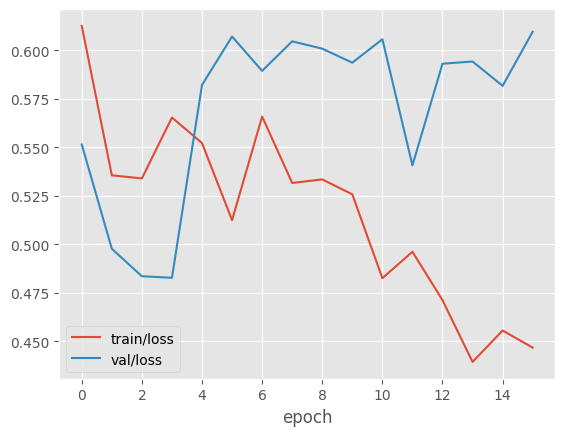

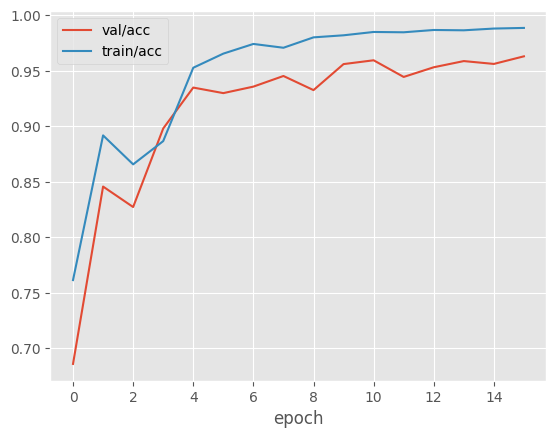

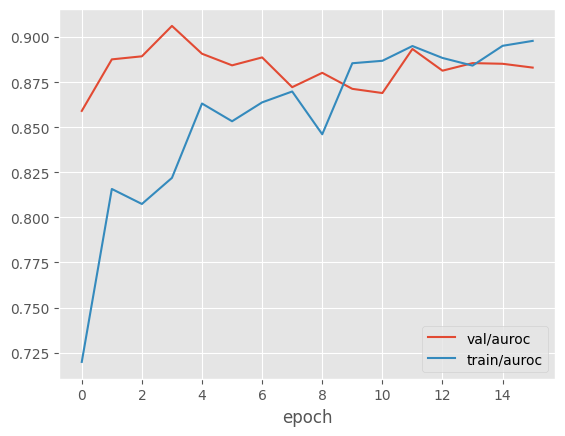

In [25]:
for key in ['loss', 'acc', 'auroc']:
    df_hist[[c for c in df_hist.columns if key in c]].plot()

## Predict

In [26]:
dl_test = dm.test_dataloader()
rs = trainer.test(net, dataloaders=[dl_train, dl_val, dl_test])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9940714240074158     │    0.9837142825126648     │    0.9776785969734192     │
│        test/auroc         │    0.9704669713973999     │    0.9442037343978882     │    0.9279600381851196     │
│         test/loss         │    0.3498562276363373     │    0.6095715761184692     │    0.6334336400032043     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

In [27]:
dl_test = dm.test_dataloader()
r = trainer.predict(net, dataloaders=dl_test)
y_test_pred = np.concatenate(r)
y_test_pred.shape

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

(7000, 2)

In [28]:
df_test = dm.df.iloc[dm.test_split:].copy()
df_test['probe_pred'] = y_test_pred.argmax(-1)
df_test['probe_prob'] = y_test_pred[:, 1]
df_test['llm_prob'] = (df_test['ans1']+df_test['ans2'])/2
df_test['llm_ans'] = df_test['llm_prob']>0.5
df_test['conf'] = (df_test['ans1']-df_test['ans2']).abs()

y_true = dl_test.dataset.tensors[2].numpy()
assert ((df_test['y'].values>0.5)==(y_true>0.5)).all(), 'check it all lines up'

df_test

,desired_answer,input,lie,true_answer,version,ans1,ans2,true,dir_true,conf,llm_prob,llm_ans,y,probe_pred,probe_prob
21000,False,Review Title: Keeps my Fibrox sharp\n\nReview ...,True,1,lie,0.526367,0.845215,1,0.318848,0.318848,0.685791,True,0.0,0,6.605214e-05
21001,True,Review Title: I feel stupid for buying this bo...,True,0,lie,0.071533,0.080261,0,0.008728,0.008728,0.075897,False,0.0,0,1.562882e-18
21002,True,Review Title: Hide 'N NO Seek Care Bear\n\nRev...,True,0,lie,0.145874,0.373535,0,0.227661,0.227661,0.259705,False,0.0,0,3.331544e-11
21003,True,Review Title: doesn't work well\n\nReview Cont...,True,0,lie,0.359131,0.106567,0,-0.252563,0.252563,0.232849,False,0.0,0,5.364013e-26
21004,True,Review Title: horribly overrated\n\nReview Con...,True,0,lie,0.067505,0.051056,0,-0.016449,0.016449,0.059280,False,0.0,0,5.347889e-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,True,Review Title: Great for burning CDS\n\nReview ...,False,1,truth,0.522949,0.745117,1,0.222168,0.222168,0.634033,True,0.0,0,3.535625e-05
27996,False,Review Title: Horrible...\n\nReview Content: I...,False,0,truth,0.001739,0.001056,0,-0.000683,0.000683,0.001397,False,0.0,0,8.407791e-45
27997,False,Review Title: one of the worst books to use fo...,False,0,truth,0.016632,0.000480,0,-0.016152,0.016152,0.008556,False,0.0,0,8.033644e-42
27998,False,"Review Title: Not for C, C++ programmers\n\nRe...",False,0,truth,0.005379,0.008308,0,0.002930,0.002930,0.006844,False,0.0,0,3.074781e-38


In [29]:
def get_acc_subset(df, query):
    df_s = df.query(query)
    acc = (df_s['probe_pred']==df_s['y']).mean()
    print(f"acc={acc:2.2%} [{query}]")
    
print('probe results on subsets of the data')
get_acc_subset(df_test, 'lie==True') # it was ph told to lie
get_acc_subset(df_test, 'lie==False') # it was told not to lie
get_acc_subset(df_test, 'llm_ans==true_answer') # the llm gave the true ans
get_acc_subset(df_test, 'llm_ans==desired_answer') # the llm gave the desired ans
get_acc_subset(df_test, 'lie==True & llm_ans==desired_answer') # it was told to lie, and it did lie
get_acc_subset(df_test, 'lie==True & llm_ans!=desired_answer')

probe results on subsets of the data
acc=92.40% [lie==True]
acc=99.51% [lie==False]
acc=98.77% [llm_ans==true_answer]
acc=94.62% [llm_ans==desired_answer]
acc=57.55% [lie==True & llm_ans==desired_answer]
acc=97.63% [lie==True & llm_ans!=desired_answer]


In [30]:
acc_truth = (df_test['probe_pred']==(df_test['llm_ans']>0.5)).mean()
print(f"lightning model acc at predicting the models public answer (not what it's trained for): {acc_truth:2.2%}")

lightning model acc at predicting the models public answer (may not what it's trained for): 52.21%


## Task results

E.g. how well does the underlying language model do on the task

It's suprisingly hard to get it to lie without telling it to (which can cause data leakage). So with this prompting setup 10-20% is good, even for an uncensored model.

In [31]:
print('Can the model lie?')
c_in = df_test.query('lie==True')
(c_in['desired_answer']==c_in['llm_ans']).mean()

Can the model lie?


0.13057142857142856

: 